# Testing data integrity

first going to try and identify any uncropped images, such as:

(505, 766)


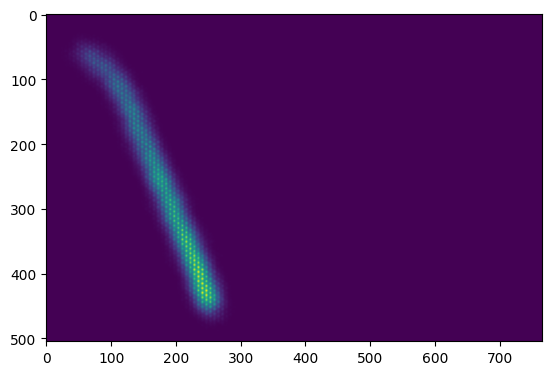

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../ANN-code'))

import matplotlib.pyplot as plt
import numpy as np

sus_image_file = "../ANN-code/Data/im0/604.960keV_0.000_0.000_C_2.210cm_4704_im.npy"

image = np.load(sus_image_file)
print(image.shape)
np.savetxt("image.csv", image, delimiter=",")

plt.imshow(image)
plt.show()

so this recoil is uncropped in x. i have planted it in the local data so it can be extracted as a test.

method i'm employing to find these problematic images:

1. Check image max_x e.g. from max_y, max_x = image.shape
2. Check largest x value max_nonzero_x with nonzero intensity (with non-noisy images)
3. Compare based on some criteria e.g. if max_nonzero_x < search_fraction * max_x 
4. Return a list of all images that satisfy this
5. Check through by hand, and adjust search fraction.
6. Repeat with same criteria for y

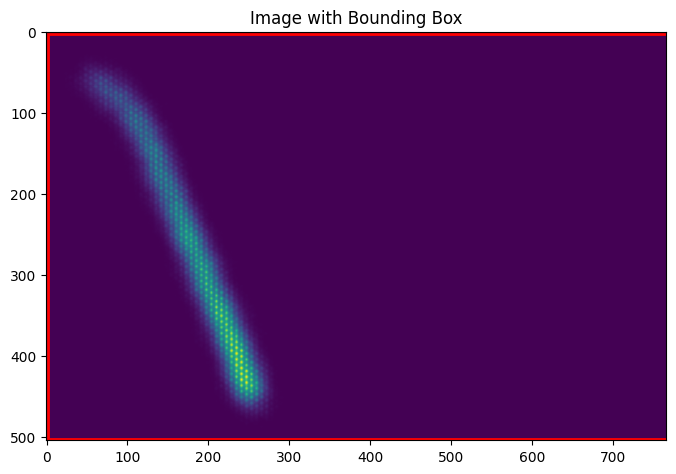

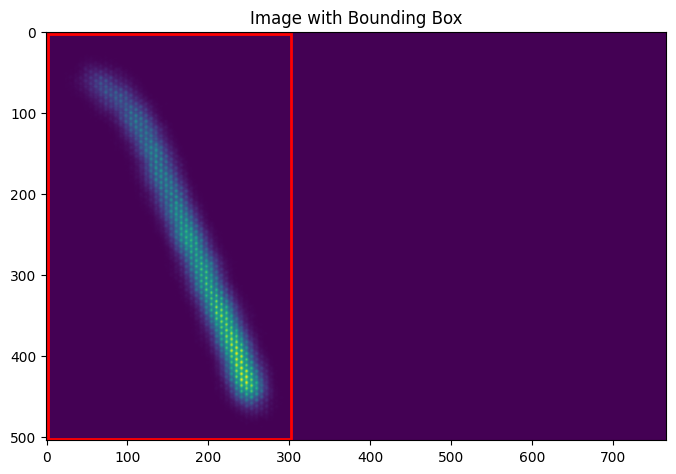

0.3864746787994726


In [2]:
# testing bounding box ID

from feature_extraction import extract_bounding_box
from image_preprocessing import zero_edges
from image_analysis import plot_bounding_box

# plot image with bounding box
bounding_box = extract_bounding_box(image)
plot_bounding_box(image, bounding_box)

# now zero edges and plot again
image = zero_edges(image)
bounding_box = extract_bounding_box(image)
plot_bounding_box(image, bounding_box)

# area of bounding box / area of image
area_bb = (bounding_box[2] - bounding_box[0]) * (bounding_box[3] - bounding_box[1])
area_image = image.shape[0] * image.shape[1]
print(area_bb / area_image)

In [ ]:
from data_methods import create_file_paths
from bb_event import Event

data_path = ["../ANN-code/Data/im0"]

file_paths = create_file_paths(data_path)

events = []
file_paths = np.random.choice(file_paths, size=10, replace=True)
for file in file_paths:
    events.append(Event(file, np.load(file)))

print("Number of events loaded: ", len(events))

In [ ]:
# for the 10 events, plot the image with bounding box, then zero edges and plot again. repeat with new figure for each event

for event in events:
    image = event.image
    bounding_box = extract_bounding_box(image)
    plot_bounding_box(image, bounding_box)
    image = zero_edges(image, 5)
    bounding_box = extract_bounding_box(image)
    plot_bounding_box(image, bounding_box)
    print("Bounding box: ", bounding_box)
    # calculate bounding box area
    area = (bounding_box[2] - bounding_box[0]) * (bounding_box[3] - bounding_box[1])
    print("Bounding box area: ", area)
    total_area = image.shape[0] * image.shape[1]
    print("Total area: ", total_area)
    # print ratio of bounding box area to total area
    print("Ratio of bounding box area to total area: ", area / total_area)
    plt.show()
    plt.close()

# need to determine an unusual bounding box area / total area ratio threshold to determine if an event is unusual
# for now, below 0.5 is unusual

In [7]:
# checking for problematic images using my test functions
import os
import sys
from tqdm import tqdm

print("Current working directory: ", os.getcwd())

from image_preprocessing import uncropped_check, dim_check, zero_edges


# Directories to check
im_dirs = [
    "../ANN-code/Data/im0",
    ]

# check all images in the directory (end in .npy)
min_dim_error = []
uncropped_error = []

# ssearch criteria
min_dim = 20

for im_dir in im_dirs:
    for file in tqdm(os.listdir(im_dir)):
        if file.endswith(".npy"):
            im_file = os.path.join(im_dir, file)
            image = np.load(im_file)

            if dim_check(image, min_dim):
                min_dim_error.append(im_file)
                continue

            if uncropped_check(image, search_fraction=0.8, method='max_comparison'):
                uncropped_error.append(im_file)
                continue

            if uncropped_check(zero_edges(image, 5), search_fraction=0.6, method='area_comparison'):
                uncropped_error.append(im_file)
                

print("Number of images that violate the minimum dimension criteria: ", len(min_dim_error))
print("Number of images that violate the uncropped criteria: ", len(uncropped_error))

# save the min_dim_error and uncropped_error lists as csv files

# np.savetxt("min_dim_error.csv", min_dim_error, delimiter=",", fmt="%s")
# np.savetxt("uncropped_error.csv", uncropped_error, delimiter=",", fmt="%s")


Current working directory:  /Users/benstevens/MIGDAL/NR-ANN/notebooks


100%|██████████| 2027/2027 [00:01<00:00, 1513.14it/s]

Number of images that violate the minimum dimension criteria:  9
Number of images that violate the uncropped criteria:  2


In [ ]:
# now manual check

# widget for manual check
import sys, os
sys.path.append(os.path.abspath('../ANN-code'))

from bb_event import Event
import random
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, VBox, HBox, Output, Label

# Load uncropped events (change if needed)
uncropped = np.loadtxt('../ANN-code/uncropped_error.csv', delimiter=',', dtype=str)

# Initialize events
events = []
for file in uncropped:
    im = np.load(file)
    events.append(Event(file, im))

# Track corrected events
corrected_list = []

# Initialize output
out = Output()

# Display next event
def display_event():
    with out:
        out.clear_output()
        if events:
            event = random.choice(events)
            events.remove(event)
            plt.imshow(event.image, cmap='gray')
            plt.title(event.name)
            plt.axis('off')
            plt.show()
            return event
        else:
            print("No more events to inspect!")
            return None

# Event to inspect
current_event = display_event()

# Handle "Accept" button
def accept_event(b):
    global current_event
    with out:
        if current_event:
            print(f"Accepted event: {current_event.name}")
        current_event = display_event()


# Handle "Reject" button
def reject_event(b):
    global current_event
    with out:
        if current_event:
            corrected_list.append(str(current_event.name))
            print(f"Rejected event: {current_event.name}")
        current_event = display_event()

# Create buttons
accept_button = Button(description="Accept", button_style="success")
reject_button = Button(description="Reject", button_style="danger")

# Button click handlers
accept_button.on_click(accept_event)
reject_button.on_click(reject_event)

# Layout
label = Label(f"Remaining events: {len(events)}")
def update_label():
    label.value = f"Remaining events: {len(events)}"

def update_event_list(b):
    update_label()

accept_button.on_click(update_event_list)
reject_button.on_click(update_event_list)

buttons = HBox([accept_button, reject_button])
layout = VBox([label, buttons, out])

# Display
display(layout)

In [ ]:
print(corrected_list)